FaST-LMM: New Features for 2021 & 2022
=====

*updated: 4/25/2024*

This notebook demonstrates these new features of FaST-LMM's `single_snp` function:

* effect size
* multiple phenotypes
* filtering output by p-value and random sampling
* caching to divide the work into parts (useful for running jobs that run from several hours to several days.)
* controlling multi-processor runs

and these [new features of `epistasis`](#epistasis):

* reports β, the linear coefficient of the epistatic interaction, and its variance
* supports a user-supplied eigenvalue decomposition of the Realized Relationship Matrix (RRM) matrix

The notebook is an addition to the [main FaST-LMM notebook](https://github.com/fastlmm/FaST-LMM/blob/master/doc/ipynb/FaST-LMM.ipynb).

To prepare this notebook to run analyses, please run the following script.

In [1]:
# set some ipython notebook properties
%matplotlib inline

# set degree of verbosity (adapt to INFO for more verbose output)
import logging
logging.basicConfig(level=logging.WARNING)

# set figure sizes
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
#pylab.plot([1,2,3],[4,5,6])

# set display width for pandas data frames
import pandas as pd
pd.set_option('display.width', 1000)

## Effect Size

The `single_snp` function now returns the effect size of the SNP. EffectSize is `SNPWeight^2 * "raw" test SNP variance / phenotype variance`, where
* SNPWeight is the beta for the “standardized test SNP” (where "standardized" means made to have mean 0, stdev 1)
* "raw" means the original test SNP values of “0,1,2” (the count of allele 1 or 2 [it doesn’t matter])
* The phenotype’s original values are used (so, they are not, for example, changed by regressing out the covariates)

## Multiple Phenotype

Previous version of `single_snp` looked for associations between SNPs and one phenotype. The new version supports multiple phenotypes, for example multiple conditions or diseases. The number of phenotypes can be a few, dozens, or thousands. Testing multiple phenotypes in one run is much faster than testing them one at a time.

In this example, we'll expand the example from the [main FaST-LMM notebook](https://github.com/fastlmm/FaST-LMM/blob/master/doc/ipynb/FaST-LMM.ipynb). Along with the original phenotype, for demonstration purposes, we'll also test its square and cube. We'll create this new phenotype data in memory, but you'll typically, instead, just read multiple phenotypes from a single file.

In [2]:
import numpy as np
from pysnptools.snpreader import Pheno, SnpData
from fastlmm.util import example_file # Download and return local file name

# For example, create multiple phenotype in memory
##############################
pheno1 = Pheno(example_file("tests/datasets/synth/pheno_10_causals.txt")).read()
pheno3 = SnpData(iid=pheno1.iid,
                 sid=["original","sqrt","square"],
                 val= np.c_[pheno1.val,pheno1.val**2,pheno1.val**3]
)

We run just as in the main FaST-LMM notebook but with pheno3, which contains multiple phenotypes.

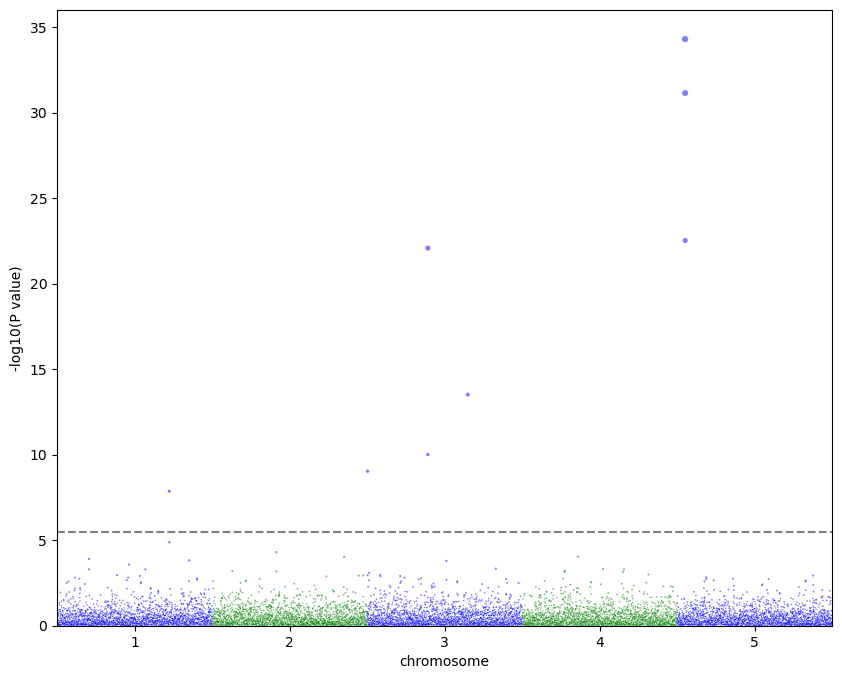

lambda=1.0126


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,EffectSize,Mixing,Nullh2,Pheno,PhenoCount
0,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,4.970585e-35,3.069400,0.229633,0.011049,0,0.300930,square,3
1,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,7.180109e-32,-0.872371,0.069123,0.010028,0,0.451557,sqrt,3
2,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,2.990684e-23,0.418653,0.040052,0.007373,0,0.451117,original,3
3,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,8.251922e-23,-0.416495,0.040300,0.082526,0,0.279710,original,3
4,650,snp1200_m0_.37m1_.36,3.0,2650.0,2650.0,3.048007e-14,0.328870,0.042021,0.054986,0,0.279710,original,3
5,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,9.732331e-11,-1.691786,0.255819,0.037965,0,0.263895,square,3
6,3,snp433_m0_.14m1_.11,3.0,2003.0,2003.0,9.202499e-10,-0.268289,0.042973,0.016289,0,0.279710,original,3
7,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.383880e-08,1.480571,0.256529,0.000605,0,0.417260,square,3
8,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.308581e-05,-0.340112,0.077247,0.000359,0,0.495164,sqrt,3
9,415,snp1166_m0_.08m1_.1,2.0,1415.0,1415.0,5.007490e-05,-0.315055,0.077009,0.005493,0,0.509244,sqrt,3


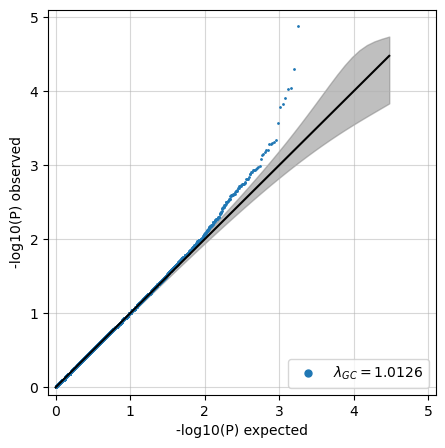

In [3]:
# import the algorithm
import numpy as np
from fastlmm.association import single_snp
from fastlmm.util import example_file # Download and return local file name

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
cov_fn = example_file("tests/datasets/synth/cov.txt")

# run gwas with pheno3
###################################################################
results_df = single_snp(bed_fn, pheno3, covar=cov_fn, count_A1=False)

# manhattan plot
import pylab
import fastlmm.util.util as flutil
pylab.rcParams['figure.figsize'] = (10.0, 8.0)#For some reason, need again (appears above too) to get big figures
flutil.manhattan_plot(results_df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=1e-5/pheno3.sid_count,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
plotp.qqplot(results_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

Running with multiple phenotypes differs from running with a single phenotype in these ways:

### More output lines (and tougher p-value threshold for significance)

Instead of one output line per test SNP, we receive one output line per \[test SNP, phenotype\] pair. In the example, we have 5000 test SNPs and three phenotypes, so the number of output lines will be 15,000.

As before, each output line will contain one p-value. Because we are testing more hypotheses, we need adjust the p-value threshold for significance. For example, if that threshold was 1e-5 for one phenotype, then the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) says that for three phenotypes should be 1e-5 divided by 3.

### New columns

The output contains two new columns: `Pheno` and `PhenoCount`. In this case, `Pheno` will be 'Original', 'Square', or 'Cube'. `PhenoCount` will be 3.

### Missing data handling

For a given individual, phonotype data must be entirely present or entirely missing. A user with some phenotype data present and some missing is not supported. In detail:

* For a given individual, all phenotype data is present -- individual is included in computation.
* For a given individual, all phenotype is missing -- individual is removed from computation.
* For a given individual, some phenotype is present and some is missing -- an error is raised.

In the last case, if an error is raised, we would either need to fix the data before giving it `single_snp` (perhaps by filling in missing data or by removing the individual) or create a loop around `single_snp` and running one phenotype at a time. Note that the 'create a loop' method is slower and produces results based on different subsets of individuals.

### No support for 2nd kernel

The `single_snp` function supports multiple similarity kernels when the number of phentotypes is 1. When multiple phenotypes are given, no second kernel is allowed.

## Filtering Output by p-value and Random Sampling

The `single_snp` function may compute more p-values that we wish to see in the output. Two new options let us filter out less interesting rows.

Use `pvalue_threshold` to include all p-values smaller than the given threshold. With this we can create a censored Manhatten plot that shows the interesting values and some less interesting values, but that excludes very uninteresting values.

Use `random_threshold` to include a random sample of output lines. Sampling works by first assigning each potential output line a random number drawn from a uniform distribution between 0.0 and 1.0. The program then checks if that random number is below our random threshold. With a random sample of output lines, we can create a Q-Q plot that lets us know whether the model is controlling for type-I error.

2051


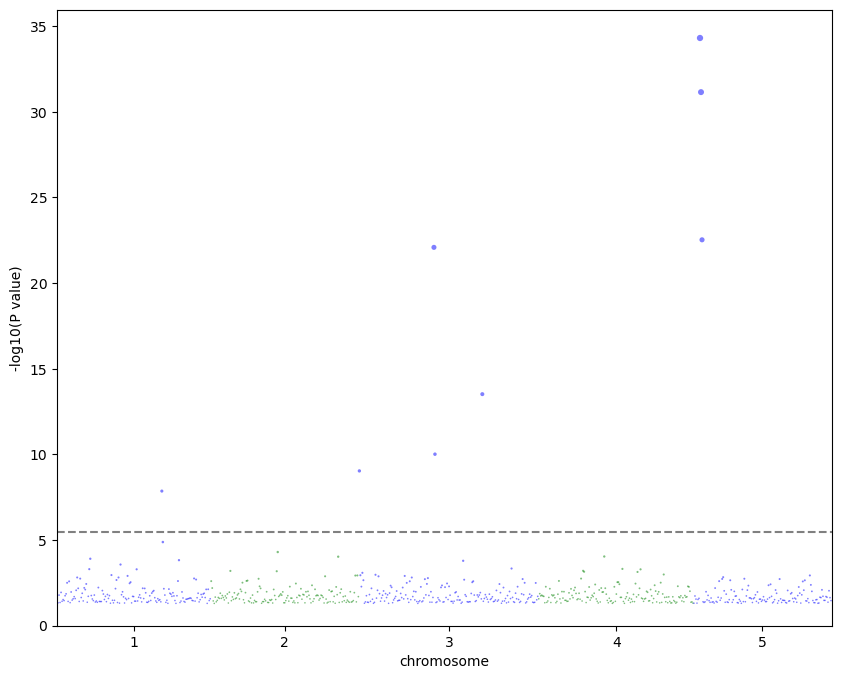

lambda=0.9231


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,EffectSize,Mixing,Nullh2,Pheno,PhenoCount,PValueThreshold,RandomValue,RandomThreshold,RandomSeed,PValueCount
0,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,4.970585e-35,3.069400,0.229633,0.011049,0,0.300930,square,3,0.05,0.429538,0.1,0,3000
1,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,7.180109e-32,-0.872371,0.069123,0.010028,0,0.451557,sqrt,3,0.05,0.771803,0.1,0,3000
2,52,snp495_m0_.01m1_.04,5.0,4052.0,4052.0,2.990684e-23,0.418653,0.040052,0.007373,0,0.451117,original,3,0.05,0.155787,0.1,0,3000
3,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,8.251922e-23,-0.416495,0.040300,0.082526,0,0.279710,original,3,0.05,0.707699,0.1,0,3000
4,650,snp1200_m0_.37m1_.36,3.0,2650.0,2650.0,3.048007e-14,0.328870,0.042021,0.054986,0,0.279710,original,3,0.05,0.540116,0.1,0,3000
5,392,snp1422_m0_.49m1_.5,3.0,2392.0,2392.0,9.732331e-11,-1.691786,0.255819,0.037965,0,0.263895,square,3,0.05,0.697988,0.1,0,3000
6,3,snp433_m0_.14m1_.11,3.0,2003.0,2003.0,9.202499e-10,-0.268289,0.042973,0.016289,0,0.279710,original,3,0.05,0.086047,0.1,0,3000
7,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.383880e-08,1.480571,0.256529,0.000605,0,0.417260,square,3,0.05,0.055916,0.1,0,3000
8,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.308581e-05,-0.340112,0.077247,0.000359,0,0.495164,sqrt,3,0.05,0.102950,0.1,0,3000
9,415,snp1166_m0_.08m1_.1,2.0,1415.0,1415.0,5.007490e-05,-0.315055,0.077009,0.005493,0,0.509244,sqrt,3,0.05,0.433384,0.1,0,3000


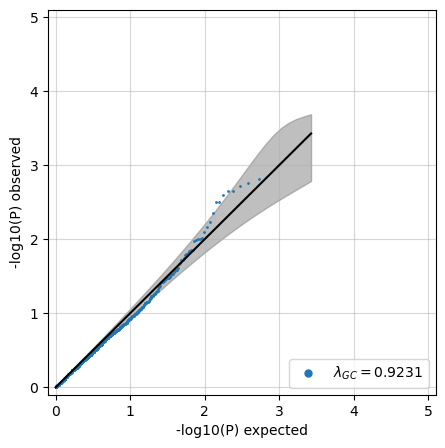

In [4]:
# import the algorithm
import numpy as np
from pysnptools.snpreader import Pheno
from fastlmm.association import single_snp
from fastlmm.util import example_file # Download and return local file name

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
cov_fn = example_file("tests/datasets/synth/cov.txt")
pheno1 = Pheno(example_file("tests/datasets/synth/pheno_10_causals.txt")).read()
pheno3 = SnpData(iid=pheno1.iid,
                 sid=["original","sqrt","square"],
                 val= np.c_[pheno1.val,pheno1.val**2,pheno1.val**3]
)

# run gwas
###################################################################
results_df = single_snp(bed_fn, pheno3, covar=cov_fn, count_A1=False, pvalue_threshold=5e-2, random_threshold=.1)
print(len(results_df))

# manhattan plot
import pylab
import fastlmm.util.util as flutil
pylab.rcParams['figure.figsize'] = (10.0, 8.0)#For some reason, need again (appears above too) to get big figures
top_pvalues_df = results_df[results_df['PValue']<=results_df['PValueThreshold']]
flutil.manhattan_plot(top_pvalues_df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=1e-5/pheno3.sid_count,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
random_df = results_df[results_df['RandomValue']<=results_df['RandomThreshold']]
plotp.qqplot(random_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

In this example, using a `PValueThreshold` and `RandomThreshold` lets us reduce the number of output lines from 15,000 to 2,051. Filtering becomes even more important when the number of \[test SNP, phenotypes\] pairs is in the millions or billions. Filtering allows us to reduce output line from billions to, say, tens of thousands.

Setting either `PValueThreshold` or  `RandomThreshold` produces this new column in the output:

* `PValueCount` -- the number of p-values computed. This is the number of output lines that will be produced with no filtering. It is also the number of \[test SNPs,  phenotype pairs\]. In the example, it is 15,000.

Setting a `PValueThreshold` produces this column:

* `PValueThreshold` -- the `PValueThreshold` used

Setting a `RandomThreshold` produces these columns:

* `RandomValue` -- the random value assigned to this output row
* `RandomThreshold` -- the `RandomThreshold` used
* `RandomSeed` -- the random seed used

## Caching to Divide the Work into Parts

Internally, the `single_snp` function works in two parts:

* Part 1 -- Merge similarity kernel information with covariate and phenotype information, process the kernel(s) via a matrix operation (SVD), and find best mix between kernel(s) and the identity matrix. (By default, do this with respect to each chromosome.)

* Part 2 -- Test SNPs

Caching lets us save the results from Part 1 before doing Part 2. In addition, if we have cached results for Part 1, we can easily do Part 2 pieces. This is especially useful if the parts take days to run. It also makes it easy to run Part 2 on multiple computers.

Let's rerun our example with this caching. First, we do a run that will save Part 1's results to the cache files. This run still requires some test SNPs, so we give it just one test SNP per chromosome and ignore the results.

Listing the files in the cache folder we see a file(s) created for each chromosome. Only runs with multiple phenotypes will have '*.extra.npz' files.

In [5]:
# import the algorithm
import os
import numpy as np
from pysnptools.snpreader import Bed, Pheno
from fastlmm.association import single_snp
from fastlmm.util import example_file # Download and return local file name

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
all_snps = Bed(example_file('tests/datasets/synth/all.*','*.bed'),count_A1=False)
# Find one test_snps per chromsome
index_to_1_snp_per_chrom = np.unique(all_snps.pos[:,0],return_index=True)[1]
small_test_snps = all_snps[:,index_to_1_snp_per_chrom]

cov_fn = example_file("tests/datasets/synth/cov.txt")
pheno1 = Pheno(example_file("tests/datasets/synth/pheno_10_causals.txt")).read()
pheno3 = SnpData(iid=pheno1.iid,
                 sid=["original","sqrt","square"],
                 val= np.c_[pheno1.val,pheno1.val**2,pheno1.val**3]
)

# run gwas
###################################################################
ignore_df = single_snp(test_snps=small_test_snps, K0=all_snps, pheno=pheno3, covar=cov_fn, count_A1=False,
             cache_file="cache/fastlmm2021sample")

os.listdir("cache")


['fastlmm2021sample.1.0.npz',
 'fastlmm2021sample.1.0.npz.extra.npz',
 'fastlmm2021sample.2.0.npz',
 'fastlmm2021sample.2.0.npz.extra.npz',
 'fastlmm2021sample.3.0.npz',
 'fastlmm2021sample.3.0.npz.extra.npz',
 'fastlmm2021sample.4.0.npz',
 'fastlmm2021sample.4.0.npz.extra.npz',
 'fastlmm2021sample.5.0.npz',
 'fastlmm2021sample.5.0.npz.extra.npz',
 'us.npz']

Now let's test SNPs in pieces. We can divide the test SNPs any way we wish. In this example, we'll divide by chromosome.

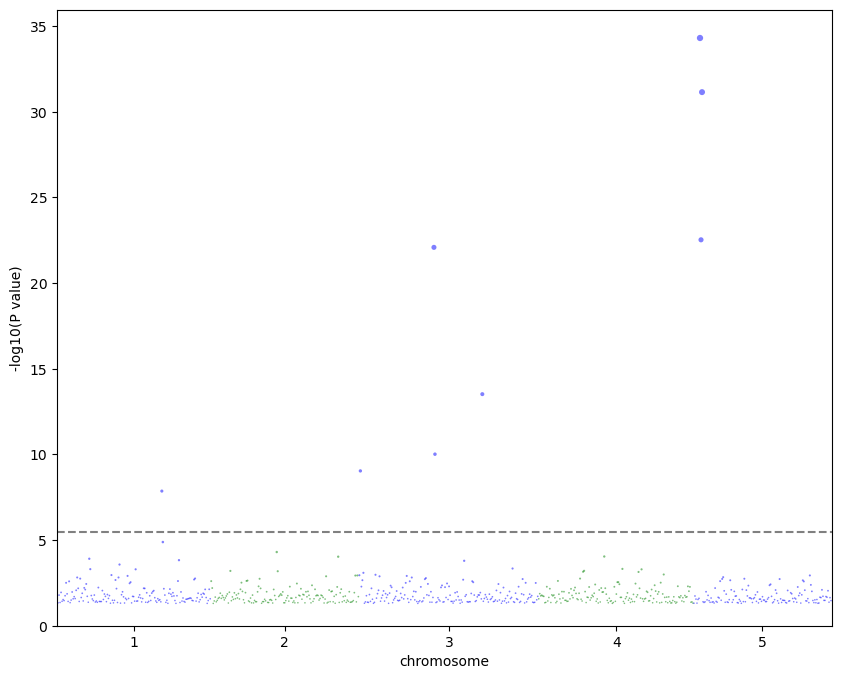

lambda=0.9231


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,EffectSize,Mixing,Nullh2,Pheno,PhenoCount,PValueThreshold,RandomValue,RandomThreshold,RandomSeed,PValueCount
0,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.383880e-08,1.480571,0.256529,0.000605,0,0.417260,square,3,0.05,0.055916,0.1,0,3000
1,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.308581e-05,-0.340112,0.077247,0.000359,0,0.495164,sqrt,3,0.05,0.102950,0.1,0,3000
2,206,snp4879_m0_.01m1_.08,1.0,206.0,206.0,1.231412e-04,1.027894,0.265577,0.002718,0,0.417260,square,3,0.05,0.941165,0.1,0,3000
3,853,snp3520_m0_.03m1_.05,1.0,853.0,853.0,1.493474e-04,1.003177,0.262495,0.002430,0,0.417260,square,3,0.05,0.485523,0.1,0,3000
4,465,snp2263_m0_.33m1_.55,1.0,465.0,465.0,2.682321e-04,0.295622,0.080539,0.013884,0,0.495164,sqrt,3,0.05,0.900238,0.1,0,3000
5,206,snp4879_m0_.01m1_.08,1.0,206.0,206.0,4.993080e-04,-0.277294,0.079131,0.002222,0,0.495164,sqrt,3,0.05,0.357896,0.1,0,3000
6,571,snp3264_m0_.69m1_.51,1.0,571.0,571.0,5.098300e-04,0.277261,0.079251,0.011858,0,0.495164,sqrt,3,0.05,0.110969,0.1,0,3000
7,389,snp2136_m0_.35m1_.29,1.0,389.0,389.0,1.104407e-03,-0.257725,0.078534,0.008628,0,0.495164,sqrt,3,0.05,0.767119,0.1,0,3000
8,535,snp513_m0_.34m1_.6,1.0,535.0,535.0,1.235205e-03,-0.906270,0.278912,0.012012,0,0.417260,square,3,0.05,0.691705,0.1,0,3000
9,460,snp2888_m0_.3m1_.22,1.0,460.0,460.0,1.526408e-03,0.832640,0.261235,0.006842,0,0.417260,square,3,0.05,0.067145,0.1,0,3000


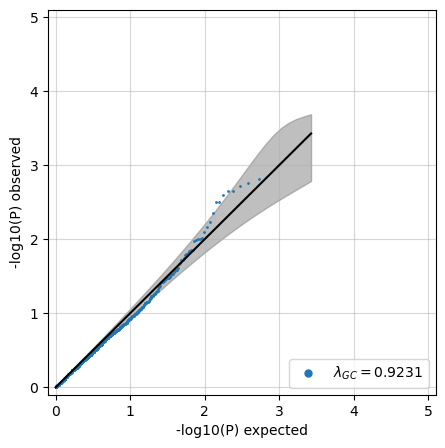

In [6]:
results_list = []
for chrom in np.unique(all_snps.pos[:,0]): # For each chrom
    test_snps = all_snps[:,all_snps.pos[:,0]==chrom] # Find the test SNPs in the chrom
    chrom_df = single_snp(test_snps=test_snps,K0=all_snps, pheno=pheno3, covar=cov_fn, count_A1=False, 
                          cache_file="cache/fastlmm2021sample",pvalue_threshold=5e-2, random_threshold=.1)
    results_list.append(chrom_df)
results_df = pd.concat(results_list)
results_df

# manhattan plot
import pylab
import fastlmm.util.util as flutil
pylab.rcParams['figure.figsize'] = (10.0, 8.0)#For some reason, need again (appears above too) to get big figures
top_pvalues_df = results_df[results_df['PValue']<=results_df['PValueThreshold']]
flutil.manhattan_plot(top_pvalues_df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=1e-5/pheno3.sid_count,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
random_df = results_df[results_df['RandomValue']<=results_df['RandomThreshold']]
plotp.qqplot(random_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

## Controlling Multi-Processor Runs

The `single_snps` function can be run on multiple processors. By default, it divides the work across processors by chromosome. In our example, this makes sense for Part 1 but not Part 2 (because we are testing one chromosome at a time). Setting `map_reduce_outer=False` will instead internally divide the work by testing SNPs in chucks.

Here is our example again, now using `runner` and `map_reduce_outer`.

In [7]:
# To clear the cache, set this to True and run
if False:
    for cache_file in os.listdir("cache"):
        os.unlink("cache/" + cache_file)

In [8]:
# import the algorithm
import numpy as np
from pysnptools.snpreader import Bed, Pheno
from pysnptools.util.mapreduce1.runner import LocalMultiProc
from fastlmm.association import single_snp
from fastlmm.util import example_file # Download and return local file name

# set up data
##############################
from fastlmm.util import example_file # Download and return local file name
all_snps = Bed(example_file('tests/datasets/synth/all.*','*.bed'),count_A1=False)
# Find one test_snps per chromsome
index_to_1_snp_per_chrom = np.unique(all_snps.pos[:,0],return_index=True)[1]
small_test_snps = all_snps[:,index_to_1_snp_per_chrom]

cov_fn = example_file("tests/datasets/synth/cov.txt")
pheno1 = Pheno(example_file("tests/datasets/synth/pheno_10_causals.txt")).read()
pheno3 = SnpData(iid=pheno1.iid,
                 sid=["original","sqrt","square"],
                 val= np.c_[pheno1.val,pheno1.val**2,pheno1.val**3]
)

# set the runner to run on multiple processors
##############################
runner = LocalMultiProc(6) #Set to None to run locally

# run gwas
###################################################################
ignore_df = single_snp(test_snps=small_test_snps, K0=all_snps, pheno=pheno3, covar=cov_fn, count_A1=False,
             cache_file="cache/fastlmm2021sample",
             runner=runner)

os.listdir("cache")

['fastlmm2021sample.1.0.npz',
 'fastlmm2021sample.1.0.npz.extra.npz',
 'fastlmm2021sample.2.0.npz',
 'fastlmm2021sample.2.0.npz.extra.npz',
 'fastlmm2021sample.3.0.npz',
 'fastlmm2021sample.3.0.npz.extra.npz',
 'fastlmm2021sample.4.0.npz',
 'fastlmm2021sample.4.0.npz.extra.npz',
 'fastlmm2021sample.5.0.npz',
 'fastlmm2021sample.5.0.npz.extra.npz',
 'us.npz']

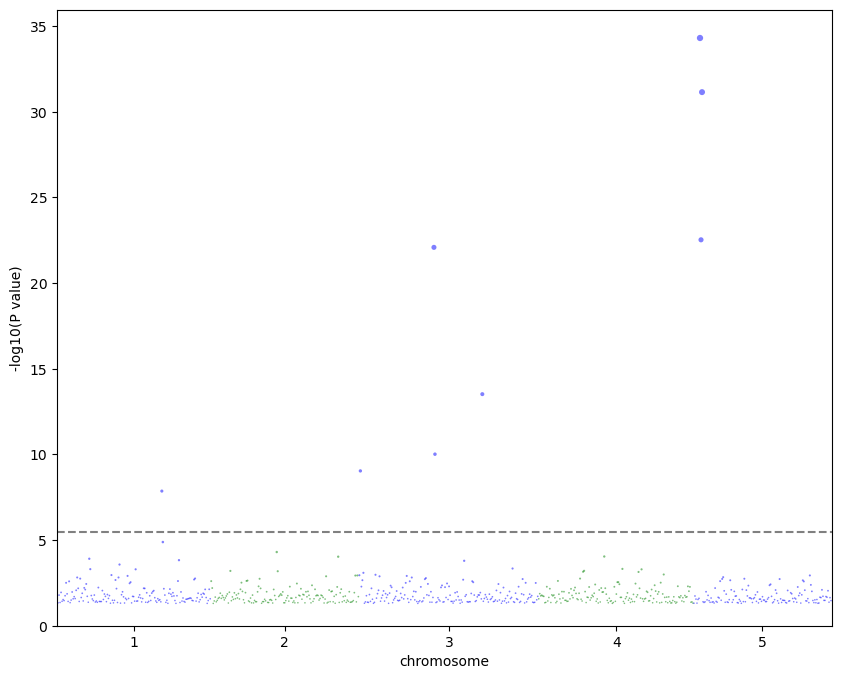

lambda=0.9231


,sid_index,SNP,Chr,GenDist,ChrPos,PValue,SnpWeight,SnpWeightSE,EffectSize,Mixing,Nullh2,Pheno,PhenoCount,PValueThreshold,RandomValue,RandomThreshold,RandomSeed,PValueCount
0,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.383880e-08,1.480571,0.256529,0.000605,0,0.417260,square,3,0.05,0.055916,0.1,0,3000
1,725,snp1386_m0_m1_.01,1.0,725.0,725.0,1.308581e-05,-0.340112,0.077247,0.000359,0,0.495164,sqrt,3,0.05,0.102950,0.1,0,3000
2,206,snp4879_m0_.01m1_.08,1.0,206.0,206.0,1.231412e-04,1.027894,0.265577,0.002718,0,0.417260,square,3,0.05,0.941165,0.1,0,3000
3,853,snp3520_m0_.03m1_.05,1.0,853.0,853.0,1.493474e-04,1.003177,0.262495,0.002430,0,0.417260,square,3,0.05,0.485523,0.1,0,3000
4,465,snp2263_m0_.33m1_.55,1.0,465.0,465.0,2.682321e-04,0.295622,0.080539,0.013884,0,0.495164,sqrt,3,0.05,0.900238,0.1,0,3000
5,206,snp4879_m0_.01m1_.08,1.0,206.0,206.0,4.993080e-04,-0.277294,0.079131,0.002222,0,0.495164,sqrt,3,0.05,0.357896,0.1,0,3000
6,571,snp3264_m0_.69m1_.51,1.0,571.0,571.0,5.098300e-04,0.277261,0.079251,0.011858,0,0.495164,sqrt,3,0.05,0.110969,0.1,0,3000
7,389,snp2136_m0_.35m1_.29,1.0,389.0,389.0,1.104407e-03,-0.257725,0.078534,0.008628,0,0.495164,sqrt,3,0.05,0.767119,0.1,0,3000
8,535,snp513_m0_.34m1_.6,1.0,535.0,535.0,1.235205e-03,-0.906270,0.278912,0.012012,0,0.417260,square,3,0.05,0.691705,0.1,0,3000
9,460,snp2888_m0_.3m1_.22,1.0,460.0,460.0,1.526408e-03,0.832640,0.261235,0.006842,0,0.417260,square,3,0.05,0.067145,0.1,0,3000


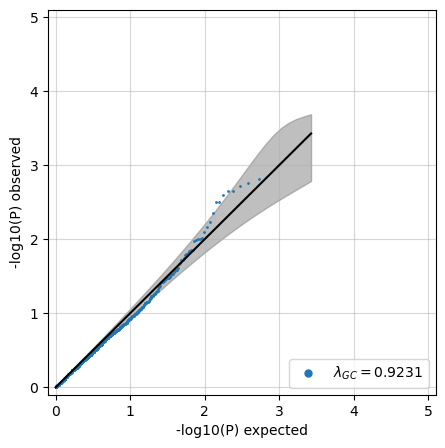

In [9]:
results_list = []
for chrom in np.unique(all_snps.pos[:,0]): # For each chrom
    test_snps = all_snps[:,all_snps.pos[:,0]==chrom] # Find the test SNPs in the chrom
    chrom_df = single_snp(test_snps=test_snps,K0=all_snps, pheno=pheno3, covar=cov_fn, count_A1=False, 
                          cache_file="cache/fastlmm2021sample",pvalue_threshold=5e-2, random_threshold=.1,
                          runner=runner, map_reduce_outer=False)
    results_list.append(chrom_df)
results_df = pd.concat(results_list)
results_df

# manhattan plot
import pylab
import fastlmm.util.util as flutil
pylab.rcParams['figure.figsize'] = (10.0, 8.0)#For some reason, need again (appears above too) to get big figures
top_pvalues_df = results_df[results_df['PValue']<=results_df['PValueThreshold']]
flutil.manhattan_plot(top_pvalues_df[["Chr", "ChrPos", "PValue"]].values,pvalue_line=1e-5/pheno3.sid_count,xaxis_unit_bp=False)
pylab.show()

# qq plot
from fastlmm.util.stats import plotp
random_df = results_df[results_df['RandomValue']<=results_df['RandomThreshold']]
plotp.qqplot(random_df["PValue"].values, xlim=[0,5], ylim=[0,5])

# print head of results data frame
import pandas as pd
pd.set_option('display.width', 1000)
results_df.head(n=10)

## Single_Snp Summary

We've seen that the `single_snp` function now supports multiple phenotypes. This support typically creates more output. Additional new features make longer runs and runs with more output more manageable.

FaST-LMM also offers the `single_snp_scale` function [(notebook)](https://github.com/fastlmm/FaST-LMM/blob/master/doc/ipynb/SingleSnpScale.ipynb). It also supports multiple phenotypes, can run on a cluster of dozens or hundreds of CPUs, and is more memory efficient. However, its memory efficiency makes it a bit slower.


<a id="epistasis"></a>
## Epistasis

Recall that FaST-LMM allows you to test for epistatic interactions between pairs of SNPs. The code optimizes (δ and thus h2) using REML, and computes P-values for an epistatic interaction via a likelihood-ratio test based on ML (see [(Lippert, et al., 2011)](https://static-content.springer.com/esm/art%3A10.1038%2Fnmeth.1681/MediaObjects/41592_2011_BFnmeth1681_MOESM290_ESM.pdf).

New for 2021, the output includes β, the linear coefficient of the epistatic interaction, and its variance. Specifically, the epistatic interaction is the product of standardized SNPs (SNPs values scaled to have mean 0 and variance 1), and is a fixed effect.

Thanks to Ava Khamseh of the University of University of Edinburgh for [her derivation of the formula for the variance](https://github.com/fastlmm/FaST-LMM/raw/epibeta/doc/notes/FaST_LMM_variance.pdf) and for requesting this feature.

Here is the example from the main FaST-LMM notebook, showing the new output columns.

In [10]:
import numpy as np
import pandas as pd
from fastlmm.association import epistasis
from pysnptools.snpreader import Bed
from fastlmm.util import example_file # Download and return local file name

# define file names
bed_fn = example_file('tests/datasets/synth/all.*','*.bed')
bed_reader = Bed(bed_fn, count_A1=True)
pheno_fn = example_file("tests/datasets/synth/pheno_10_causals.txt")
cov_fn = example_file("tests/datasets/synth/cov.txt")

# partition data into the first 50 SNPs on chr1 and all but chr1
G0 = bed_reader[:,bed_reader.pos[:,0] != 1]
test_snps = bed_reader[:,bed_reader.pos[:,0] == 1][:,0:50]

# run epistasis analysis
results_df = epistasis(test_snps, pheno_fn, G0=G0, covar=cov_fn)

# print head of results data frame
pd.set_option('display.width', 1000)
results_df.head(n=10)

,SNP0,Chr0,GenDist0,ChrPos0,SNP1,Chr1,GenDist1,ChrPos1,PValue,NullLogLike,AltLogLike,H2,Beta,Variance_Beta
0,snp2376_m0_.38m1_.49,1.0,20.0,20.0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,0.000451,-700.878718,-694.724583,0.000399,0.151714,7.372408e-07
1,snp625_m0_.03m1_.07,1.0,NaN,NaN,snp3000_m0_.28m1_.34,1.0,5.0,5.0,0.001306,-700.387891,-695.220652,0.000399,-0.117448,5.272537e-07
2,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp2377_m0_.06m1_.02,1.0,30.0,30.0,0.002279,-698.768488,-694.113511,0.000399,-0.145412,8.980881e-07
3,snp625_m0_.03m1_.07,1.0,NaN,NaN,snp376_m0_.17m1_.17,1.0,9.0,9.0,0.002287,-700.206861,-695.555229,0.000399,-0.132940,7.511802e-07
4,snp125_m0_.64m1_.41,1.0,21.0,21.0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,0.002404,-700.873861,-696.267594,0.000399,-0.131984,7.477779e-07
5,snp2878_m0_.82m1_.58,1.0,42.0,42.0,snp1878_m0_.58m1_.36,1.0,48.0,48.0,0.002568,-698.579519,-694.033792,0.000399,-0.131828,7.560385e-07
6,snp1625_m0_.4m1_.47,1.0,23.0,23.0,snp1128_m0_.14m1_.13,1.0,35.0,35.0,0.003067,-700.445456,-696.061998,0.000399,0.129267,7.540972e-07
7,snp1753_m0_.17m1_.19,1.0,28.0,28.0,snp3_m0_.55m1_.46,1.0,32.0,32.0,0.004327,-700.735073,-696.664365,0.000399,0.126579,7.791090e-07
8,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp3_m0_.55m1_.46,1.0,32.0,32.0,0.004486,-700.927439,-696.889564,0.000399,-0.120030,7.063126e-07
9,snp1753_m0_.17m1_.19,1.0,28.0,28.0,snp251_m0_.1m1_.49,1.0,33.0,33.0,0.006503,-700.728933,-697.026244,0.000399,-0.115623,7.152112e-07


## User-supplied eigenvalue decomposition for epistasis

Now, let's look at the same example where the eigenvalue decomposition of realized relationship matrix (RRM) is known.

We can provide the eigenvalues and eigenvector by writing a npz file and passing it to 'epistasis'.

To start the example, we need to create our new inputs
* S and U from the eigenvalue decomposition of the standardized RRM. Standardized means that the SNPs used to compute the matrix have mean 0 and standard deviation 1.
* A list of the individuals in the order they appear in the decomposition


In [11]:
# Precompute the decomposition of the kinship kernel.
G = G0[::-1,:] # We reverse the order of the individuals, just to show that any order is allowed
Gval = G.read().standardize().val
K = Gval.dot(Gval.T)
# So the Eigen values and vector are:
S,U = np.linalg.eigh(K)
# and the order of the individuals in the eigenvector is
eigen_iid = G.iid
print(f"{eigen_iid[:3]}...")

[['cid499P1' 'cid499P1']
 ['cid498P1' 'cid498P1']
 ['cid497P1' 'cid497P1']]...


When we have the eigenvalue decomposition, we save it to a file. We also create a "fake_G" file. The "fake_G" file is then used that to create a test SNP reader that orders individuals to match the order in the eigenvalue decomposition.

In [12]:
from pathlib import Path
from pysnptools.snpreader import SnpData
from pysnptools.util import intersect_apply


# We write the vector and the values to a npz file.
cache_file = "cache/us.npz"
Path(cache_file).parent.mkdir(exist_ok=True)
np.savez(cache_file,U,S) # note that U goes before S

# We create a fake G, the SNPs that created the kinship matrix
fake_G = SnpData(iid=eigen_iid,sid=["fake_sid"],val=np.full((test_snps.iid_count,1),np.nan))

# Reorder test_snps to match the order in the eigen_iid
fake_G_after, test_snps_reordered = intersect_apply([fake_G, test_snps])
assert np.all(fake_G_after.iid == fake_G.iid) # prove that eigen_iid are unchanged

Finally, we run epistasis using
* the test SNPs reordered to match eigen_iid
* the fake G file
* the cached file containing the decomposition

We get the same results as before.

In [13]:
df = epistasis(test_snps_reordered, pheno_fn, G0=fake_G, covar=cov_fn, cache_file=cache_file)
df.head(n=10)

,SNP0,Chr0,GenDist0,ChrPos0,SNP1,Chr1,GenDist1,ChrPos1,PValue,NullLogLike,AltLogLike,H2,Beta,Variance_Beta
0,snp2376_m0_.38m1_.49,1.0,20.0,20.0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,0.000451,-700.878718,-694.724583,0.000399,0.151714,7.372408e-07
1,snp625_m0_.03m1_.07,1.0,NaN,NaN,snp3000_m0_.28m1_.34,1.0,5.0,5.0,0.001306,-700.387891,-695.220652,0.000399,-0.117448,5.272537e-07
2,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp2377_m0_.06m1_.02,1.0,30.0,30.0,0.002279,-698.768488,-694.113511,0.000399,-0.145412,8.980881e-07
3,snp625_m0_.03m1_.07,1.0,NaN,NaN,snp376_m0_.17m1_.17,1.0,9.0,9.0,0.002287,-700.206861,-695.555229,0.000399,-0.132940,7.511802e-07
4,snp125_m0_.64m1_.41,1.0,21.0,21.0,snp1754_m0_.19m1_.42,1.0,38.0,38.0,0.002404,-700.873861,-696.267594,0.000399,-0.131984,7.477779e-07
5,snp2878_m0_.82m1_.58,1.0,42.0,42.0,snp1878_m0_.58m1_.36,1.0,48.0,48.0,0.002568,-698.579519,-694.033792,0.000399,-0.131828,7.560385e-07
6,snp1625_m0_.4m1_.47,1.0,23.0,23.0,snp1128_m0_.14m1_.13,1.0,35.0,35.0,0.003067,-700.445456,-696.061998,0.000399,0.129267,7.540972e-07
7,snp1753_m0_.17m1_.19,1.0,28.0,28.0,snp3_m0_.55m1_.46,1.0,32.0,32.0,0.004327,-700.735073,-696.664365,0.000399,0.126579,7.791090e-07
8,snp250_m0_.23m1_.19,1.0,15.0,15.0,snp3_m0_.55m1_.46,1.0,32.0,32.0,0.004486,-700.927439,-696.889564,0.000399,-0.120030,7.063126e-07
9,snp1753_m0_.17m1_.19,1.0,28.0,28.0,snp251_m0_.1m1_.49,1.0,33.0,33.0,0.006503,-700.728933,-697.026244,0.000399,-0.115623,7.152112e-07
